In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
class Node:
    #决策树的节点
    def __init__(self,depth,X=None,y=None):
        '''
        depth:当前节点的深度
        feature:节点分离数据的分叉点
        thresh: 分裂的阈值
        label:当前节点数据中出现频率最高的类别
        np.bincount(y)返回每个索引出现的次数，例如索引0存储的是class0在y中出现的次数，相应的最后一个索引应该等于y中class的最大值
        left,right:构建数的连接
        '''
        self.isleaf = None
        self.depth = depth
        self.X = X
        self.y = y
        self.n,self.m = self.X.shape
        self.best_feature = None
        self.thresh = None
        self.label = np.argmax(np.bincount(y))
        self.left = None
        self.right = None
    def gini(self,y):
        '''
        y:输入一个特征下某个属性对应的y，对y类别进行计数例如是：3，否：2
        Gini = 1 - (3/5)**2 - (2/5)**2
        '''
        s = np.bincount(y)
        N = len(y)
        gini = 1-sum((s/N)**2)
        return gini
    def gini_attr(self,left,right):
        '''
        输入二分类的两个分叉属性，计算它们的gini指数，并且返回当前特征整体的gini指数
        '''
        n1 = len(left)
        n2 = len(right)
        n = n1+n2
        return (n1/n)*self.gini(left)+(n2/n)*self.gini(right)
    
    def find_best_split(self):
        '''
        这个函数目的是找出gini系数最小的feature，以及这个feature二分类的阈值
        首先对X进行分析，每一列都是不同的feature，每一行的值就是对不同feature的取值
        先对列进行升序排序，确保返回的阈值是正确的中间分类值
        '''
        best_feature = None
        best_thresh = None
        minimum = float('inf')
        for feature in range(self.m):
            index = np.argsort(self.X[:,feature])
            X_sorted = self.X[index]
            y_sorted = self.y[index]
            for i in range(1,self.n):
                x_left = X_sorted[:i]
                x_right = X_sorted[i:]
                gini_i = self.gini_attr(x_left,x_right)
                if gini_i < minimum:
                    minimum = gini_i
                    best_feature = feature
                    best_thresh = (X_sorted[i-1,feature] + X_sorted[i,feature]) / 2
        self.best_feature = best_feature
        self.best_thresh = best_thresh
    def split(self,max_depth,min_sample_split):
        '''
        根据当前的best_feature 和 best_thresh来进行分裂。同时当达到最大深度或者将分成一类时及时停止
        并且将left,right节点进行递归计算,判断是否到达最大递归限制
        '''
        if len(self.y) < min_sample_split:
            self.isleaf = True
            return
        elif self.depth <= max_depth:
            self.isleaf = True
            return
        elif len(np.unique(self.y)) <= 1:#可分类的class只有一类
            self.isleaf = True
            return
        else:
            self.isleaf = False
            self.find_best_split()
            index_left = np.where(self.X[:self.best_feature] < self.thresh)
            index_right = np.where(self.X[self.best_feature:] >= self.thresh)
            self.left = Node(depth = self.depth + 1,X = self.X[:index_left],y = self.y[:index_left])
            self.right = Node(depth = self.depth + 1,X = self.X[index_right:],y = self.y[index_right:])
            self.left.split(max_depth, min_samples_split)
            self.right.split(max_depth, min_samples_split)
            return
    def judge(self,x):
        '''
        返回该x对应的叶子节点的值。也就是预测值
        '''
        if self.isleaf:
            return self.label
        else:
            if x[self.feature] < self.thresh: #当x的feature i小于对这个feature的阈值，往左寻找
                self.left.judge(x)
            else:
                self.right.judge(x)
        

In [14]:
class DecisionTreeClassifier:
    def __init__(self,max_depth,min_sample_split):
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
    def fit(self,X,y):
        self.root = Node(depth = 0,X = X,y = y)
        self.root.split(max_depth = self.max_depth,min_sample_split = self.min_sample_split)
        return self
    def predict(self,X):
        y = np.zeros(len(X),dtype = 'int')
        for i in range(len(X)):
            y[i] = self.root.judge(X[i])
        return y

In [15]:

from sklearn import datasets

N = 100
X, y = datasets.make_moons(n_samples = N, noise = 0.2)

xx1 = np.linspace(np.min(X[:,0]),np.max(X[:,0]),101)
xx2 = np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)
Xtest = np.array([[x1,x2] for x1 in xx1  for x2 in xx2])
xxx1, xxx2 = np.meshgrid(xx1, xx2)

def plot_result(clf):
    plt.plot(X[:,0][y==1], X[:,1][y==1],"o",label="1")
    plt.plot(X[:,0][y==0], X[:,1][y==0],"o",label="0")
    plt.legend()
    pred_val = clf.predict(Xtest)
    pred_val_2D = np.reshape(pred_val,(len(xx1),len(xx2))).T
    plt.pcolormesh(xxx1, xxx2, pred_val_2D)
    plt.colorbar()
    plt.show()

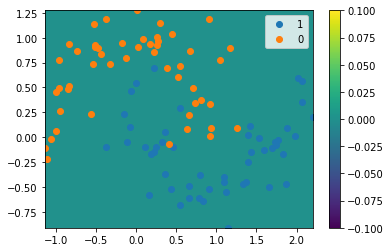

In [16]:
clf = DecisionTreeClassifier(max_depth=40, min_sample_split=2)
clf.fit(X, y)
plot_result(clf)